Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [6]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil
from tensorflow import keras
import Augmentor
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
data_dir_train = pathlib.Path("data/Train")
data_dir_test = pathlib.Path('data/Test')

In [8]:

print('cleaning data augmented folders...')
for path in pathlib.Path(data_dir_train).iterdir():
    op = pathlib.Path.joinpath(path, "output")
    if op.exists():
        print('Removing {}...'.format(op))
        shutil.rmtree(op)

cleaning data augmented folders...
Removing data/Train/actinic keratosis/output...
Removing data/Train/basal cell carcinoma/output...
Removing data/Train/dermatofibroma/output...
Removing data/Train/melanoma/output...
Removing data/Train/nevus/output...
Removing data/Train/pigmented benign keratosis/output...
Removing data/Train/seborrheic keratosis/output...
Removing data/Train/squamous cell carcinoma/output...
Removing data/Train/vascular lesion/output...


In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       shuffle=True)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2023-04-22 10:26:17.139541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 10:26:17.140364: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     shuffle=True)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

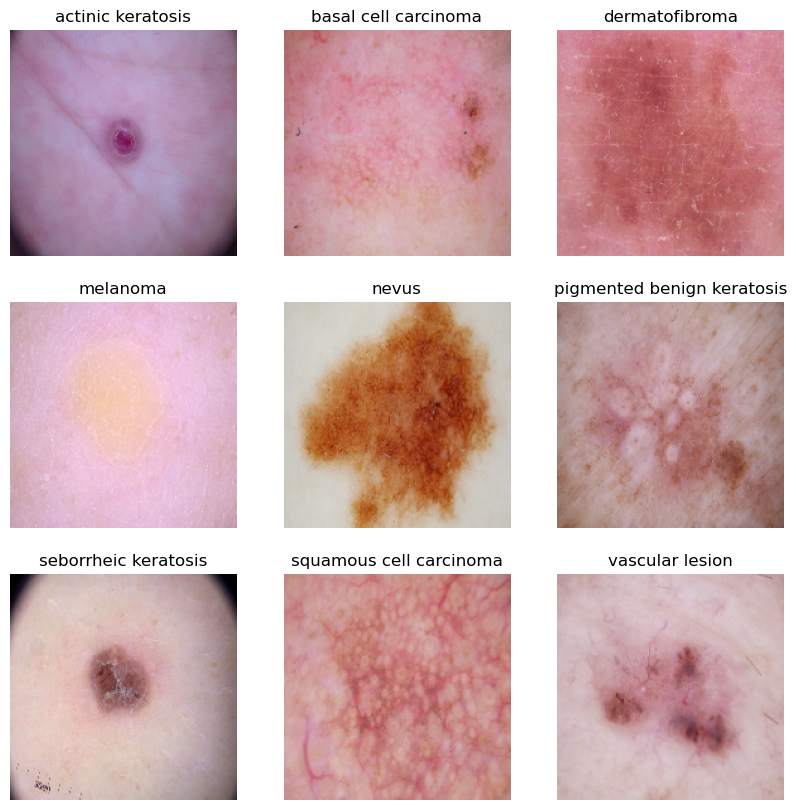

In [14]:

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[i])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

# The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3
# The label_batch is a tensor of the shape (32, 9), these are corresponding labels to the 32 images with 9 classification


(32, 180, 180, 3)
(32,)


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here
num_classes = len(class_names)

model = Sequential([
    #Normalization
    layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    #First Convolution layer
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #Second Convolution Layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #Third Convolution Layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #Flatten Layer
    layers.Flatten(),
    #Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### Todo, choose an appropirate optimiser and loss function
### sparse categorical crossentropy when your classes are mutually exclusive
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [20]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 207ms/step - loss: 2.1380 - accuracy: 0.2204 - val_loss: 2.4385 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 12s 208ms/step - loss: 1.7046 - accuracy: 0.3906 - val_loss: 2.1227 - val_accuracy: 0.2609
Epoch 3/20
56/56 [==============================] - 12s 209ms/step - loss: 1.6303 - accuracy: 0.4213 - val_loss: 2.3710 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 12s 207ms/step - loss: 1.4513 - accuracy: 0.4927 - val_loss: 3.1282 - val_accuracy: 0.2174
Epoch 5/20
56/56 [==============================] - 11s 194ms/step - loss: 1.3766 - accuracy: 0.5128 - val_loss: 2.7206 - val_accuracy: 0.2174
Epoch 6/20
56/56 [==============================] - 11s 193ms/step - loss: 1.2906 - accuracy: 0.5452 - val_loss: 2.8415 - val_accuracy: 0.2174
Epoch 7/20
56/56 [==============================] - 11s 200ms/step - loss: 1.2159 - accuracy: 0.5675 - val_loss: 3.2473 - val_accuracy: 0.2609

### Visualizing training results

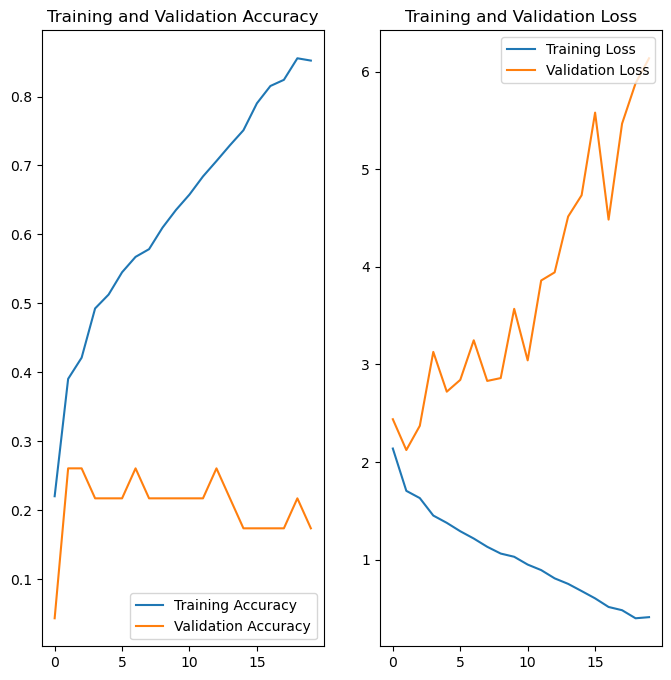

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
Training accuracy and validation accuracy are off by large margins
training accuracy: 85.21% -  validation accuracy: 17.39%
Difference between accuracy between training (greater) and validation accuracy indicates over-fitting
This means the model was unable to generalize on a new dataset


In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)



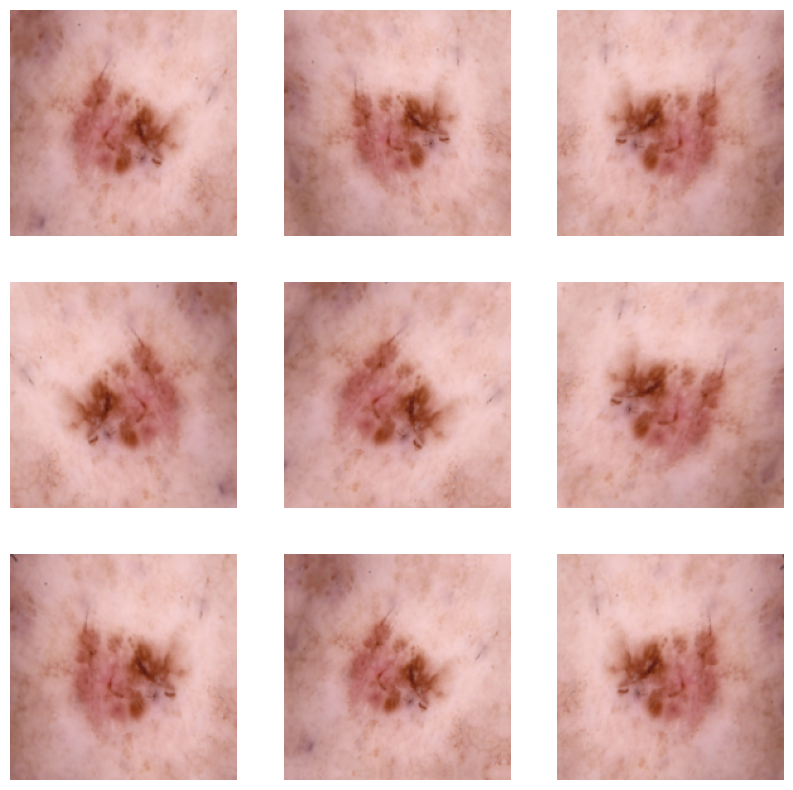

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
    data_augmentation,
    #Normalization
    layers.Rescaling(1. / 255, input_shape=(180, 180, 3)),
    #First Convolution layer
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #Second Convolution Layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #Third Convolution Layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Dropout 20%
    layers.Dropout(0.2),
    #Flatten Layer
    layers.Flatten(),
    #Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])



### Compiling the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 20s 331ms/step - loss: 2.2495 - accuracy: 0.2098 - val_loss: 2.9171 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 18s 329ms/step - loss: 1.9224 - accuracy: 0.2762 - val_loss: 2.6399 - val_accuracy: 0.1304
Epoch 3/20
56/56 [==============================] - 18s 330ms/step - loss: 1.6853 - accuracy: 0.4023 - val_loss: 2.9592 - val_accuracy: 0.2174
Epoch 4/20
56/56 [==============================] - 19s 336ms/step - loss: 1.5026 - accuracy: 0.4766 - val_loss: 2.6133 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 19s 338ms/step - loss: 1.4072 - accuracy: 0.5123 - val_loss: 3.5334 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 18s 326ms/step - loss: 1.3737 - accuracy: 0.5106 - val_loss: 2.7907 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 19s 332ms/step - loss: 1.3110 - accuracy: 0.5301 - val_loss: 2.9992 - val_accuracy: 0.1739

### Visualizing the results

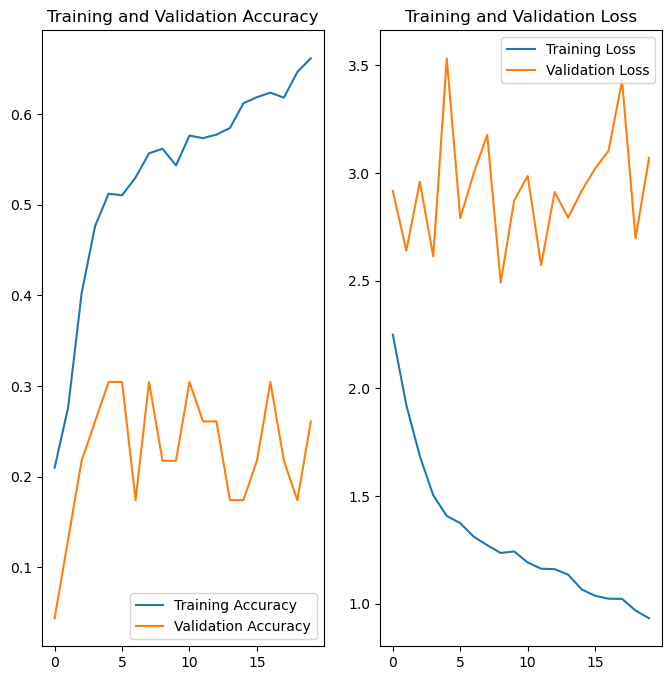

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
Training accuracy and validation accuracy are off by large margins
training accuracy: 66.18% validation accuracy: 26.09%
Difference in the accuracy between training (greater) and validation accuracy indicates over-fitting
This means the model was unable to generalize on a new dataset

There is however improvement in the model as the difference has reduced between the training and validation test albeit with lower accuracy


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
name = []
count = []
for path in pathlib.Path(data_dir_train).iterdir():
    name.append(str(path).split('/')[-1])
    count.append(len((os.listdir(path))))
data = {'Class': name,
        'No. of Image': count}
df = pd.DataFrame(data, columns=['Class', 'No. of Image'])
df

Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139

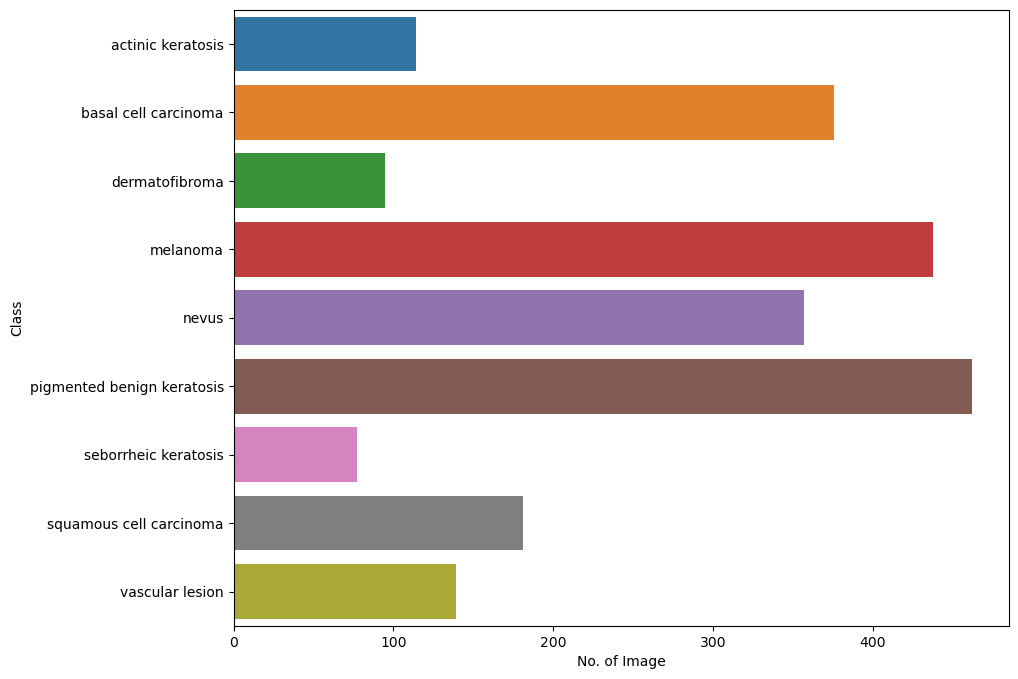

In [29]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
> seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
> pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset = "data/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(800)  ## We are adding 800 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F945BF15540>: 100%|██████████| 800/800 [00:02<00:00, 350.32 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F945BB01120>: 100%|██████████| 800/800 [00:02<00:00, 358.84 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F945BF3FA60>: 100%|██████████| 800/800 [00:02<00:00, 344.24 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=960x724 at 0x7F95A45631C0>: 100%|██████████| 800/800 [00:10<00:00, 79.65 Samples/s]                     


Initialised with 357 image(s) found.
Output directory set to data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F945BDF2530>: 100%|██████████| 800/800 [00:09<00:00, 84.59 Samples/s]                     


Initialised with 462 image(s) found.
Output directory set to data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F945B835540>: 100%|██████████| 800/800 [00:02<00:00, 351.35 Samples/s]


Initialised with 77 image(s) found.
Output directory set to data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F945BAA0730>: 100%|██████████| 800/800 [00:04<00:00, 172.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F945BB7CBE0>: 100%|██████████| 800/800 [00:02<00:00, 353.07 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F94D72765C0>: 100%|██████████| 800/800 [00:02<00:00, 347.19 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

7200


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]


In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in
                   glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]


In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = df.append(df2)

/tmp/ipykernel_25654/1687820875.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df.append(df2)


In [37]:
new_df['Label'].value_counts()

actinic keratosis             800
basal cell carcinoma          800
dermatofibroma                800
melanoma                      800
nevus                         800
pigmented benign keratosis    800
seborrheic keratosis          800
squamous cell carcinoma       800
vascular lesion               800
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
data_dir_train = "data/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9439 files belonging to 9 classes.
Using 7552 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9439 files belonging to 9 classes.
Using 1887 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [41]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential()

#Normalization
model.add(layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(180, 180, 3)))

#First Convolution layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

#Second Convolution Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

#Third Convolution Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128, activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

## Visualizing the model


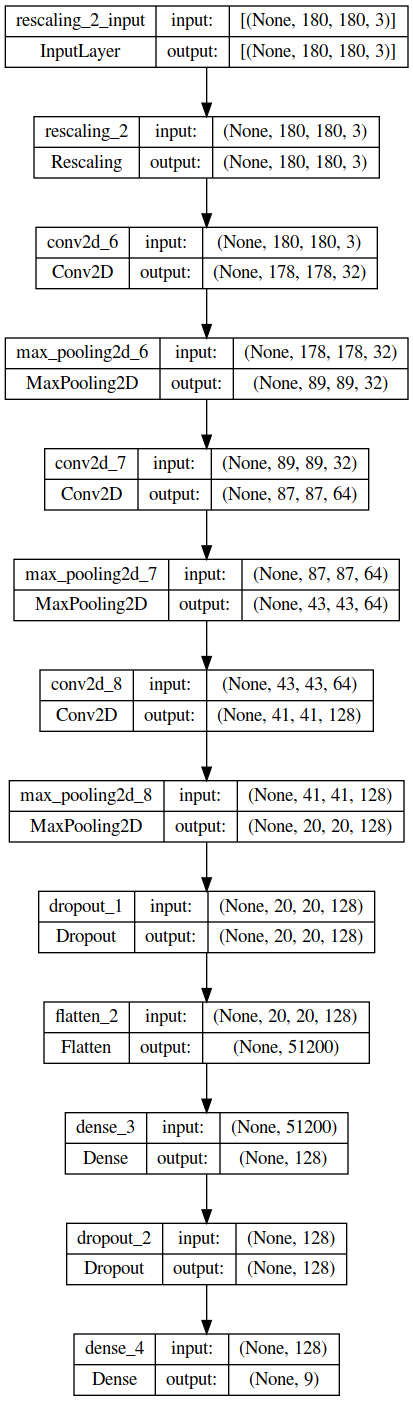

In [42]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
model.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### **Todo:**  Train your model

In [44]:
## Your code goes here, use 50 epochs.
#epochs = 50
# with early stop the performance seems to be degrading after 25, so setting epoch to 20
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[earlystop])

Epoch 1/20


/home/kuriakosej/anaconda3/envs/workspace/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


236/236 [==============================] - 87s 351ms/step - loss: 1.7694 - accuracy: 0.3089 - val_loss: 1.5122 - val_accuracy: 0.4128
Epoch 2/20
236/236 [==============================] - 83s 352ms/step - loss: 1.4386 - accuracy: 0.4515 - val_loss: 1.2533 - val_accuracy: 0.5358
Epoch 3/20
236/236 [==============================] - 82s 347ms/step - loss: 1.2517 - accuracy: 0.5246 - val_loss: 1.2419 - val_accuracy: 0.5384
Epoch 4/20
236/236 [==============================] - 87s 368ms/step - loss: 1.1160 - accuracy: 0.5847 - val_loss: 1.0193 - val_accuracy: 0.6259
Epoch 5/20
236/236 [==============================] - 82s 350ms/step - loss: 0.9703 - accuracy: 0.6284 - val_loss: 0.8843 - val_accuracy: 0.6725
Epoch 6/20
236/236 [==============================] - 82s 347ms/step - loss: 0.8552 - accuracy: 0.6823 - val_loss: 0.7586 - val_accuracy: 0.7239
Epoch 7/20
236/236 [==============================] - 83s 351ms/step - loss: 0.7237 - accuracy: 0.7312 - val_loss: 0.6944 - val_accuracy: 0.7

#### **Todo:**  Visualize the model results

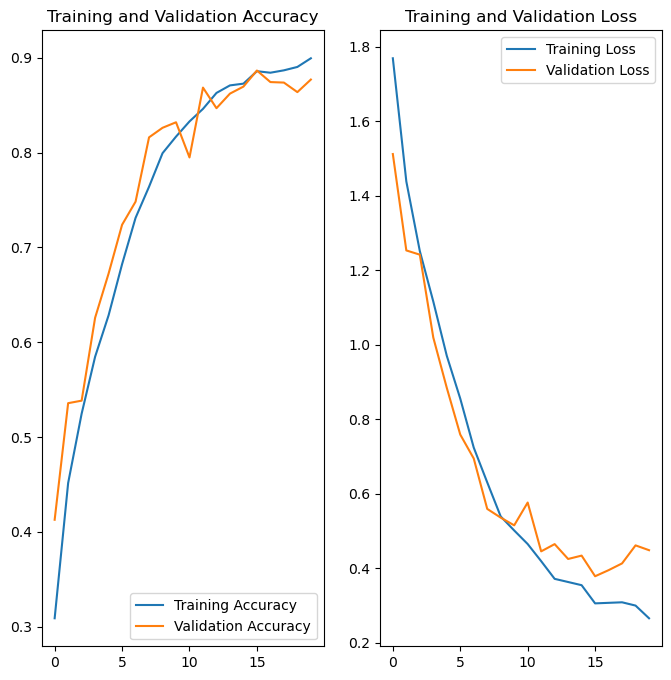

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

With the data rebalancing we were able to achieve similar accuracy for both training and validation set
training accuracy: 89.95% - validation accuracy: 87.71%
There doesn't seem to be be any overfitting / underfitting identified

# Model Prediction

1/1 [==============================] - 0s 14ms/step
Actual Class nevus
Predictive Class nevus
1/1 [==============================] - 0s 53ms/step
Actual Class melanoma
Predictive Class melanoma


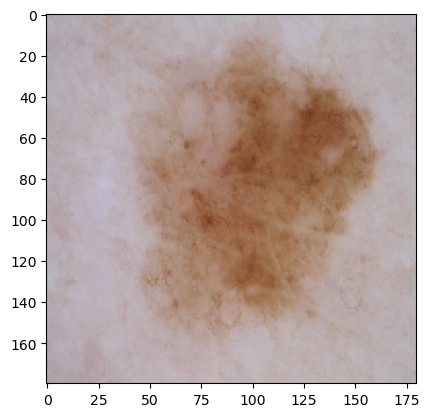

In [50]:

test_image_path = os.path.join(data_dir_test, 'nevus', '*')
test_image = glob(test_image_path)
test_image = load_img(test_image[-1],target_size=(180,180,3))

img = np.expand_dims(test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class nevus" +'\n'+ "Predictive Class "+pred_class )

###

test_image_path = os.path.join(data_dir_test, 'melanoma', '*')
test_image = glob(test_image_path)
test_image = load_img(test_image[-1],target_size=(180,180,3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class melanoma" +'\n'+ "Predictive Class "+pred_class )



# Conclusion

The model was able to identify melanoma from other skin disorders with an accuracy of 89.95%